# Project: Facial emotion recognition
# MTH767P - Group 4

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from utils import EmotionsDataset, SimpleNet, AttentionalNet

## Data loading and pre-processing 

#### Read data

In [9]:
# define dictionary for emotions
emotion_dict = {0: 'Angry', 
                1: 'Disgust', 
                2: 'Fear',
                3: 'Happy', 
                4: 'Sad',
                5: 'Surprise',
                6: 'Neutral'}

In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
batch_size = 4
dataset = EmotionsDataset(root='./data', fname='icml_face_data.csv', transform=transform)

Loading dataset...	Done


#### Visualize data


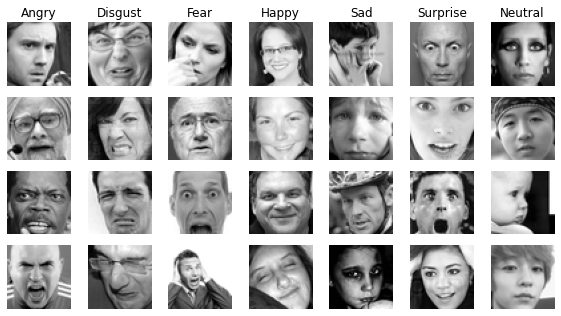

In [11]:
# generate sample of images
fig, ax = plt.subplots(batch_size, len(emotion_dict), figsize=(8, 4.5))

for i, em in emotion_dict.items():
    emotion = dataset.data[dataset.targets==i][:batch_size]
    # set title
    ax[0, i].set_title(em)
    for j in range(emotion.shape[0]):      
        im = emotion[j]
        ax[j, i].imshow(im, cmap='gray')
        ax[j, i].axis('off')
plt.tight_layout();
plt.savefig('dataset_sample.png')

### Data split

In [12]:
trainloader, testloader = dataset.split(ratio=0.8, batch_size=batch_size)

---
## Convolutional neural network setup 
### Network architecture

In [13]:
# Architecture of a simple convnet
pool = 2
f1dim = 7
f2dim = 5
nchan1 = 6
nchan2 = 16
fc1_in = nchan2 * ((((48 - f1dim + 1) // pool) - f2dim + 1) // pool)**2
l1 = dict(ltype=nn.Conv2d, in_channels=1, out_channels=nchan1, kernel_size=f1dim, stride=1, padding=0, 
          groups=1, bias=True, padding_mode='zeros')
l2 = dict(ltype=nn.Conv2d, in_channels=nchan1, out_channels=nchan2, kernel_size=f2dim, stride=1, 
          padding=0, groups=1, bias=True, padding_mode='zeros')
l3 = dict(ltype=nn.Linear, in_features=fc1_in, out_features=120, bias=True)
l4 = dict(ltype=nn.Linear, in_features=120, out_features=7, bias=True)
pooling = nn.MaxPool2d(2)
activation = F.relu
arch = {"layers": [l1,l2,l3,l4], "pooling": pooling, "activation": activation}
net_simple = SimpleNet(**arch)

In [14]:
fc1_in

1024

In [15]:
# Architecture with localization network (see Minaee 2021, and code in https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html)
net_attn = AttentionalNet()

### Loss function and optimizer

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_simple.parameters(), lr=0.001, momentum=0.9)

---
## Training the neural network
### Training

In [17]:
num_epochs = 2

for epoch in range(num_epochs): 
    running_loss = 0.0
    print(f"Epoch {epoch+1}")
    for i, data in tqdm(enumerate(trainloader)): 
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net_simple(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:  
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Epoch 1


2015it [00:17, 115.16it/s]

[1,  2000] loss: 1.788


4020it [00:35, 115.62it/s]

[1,  4000] loss: 1.665


6013it [00:53, 114.91it/s]

[1,  6000] loss: 1.575


7178it [01:03, 113.51it/s]


Epoch 2


2011it [00:17, 112.06it/s]

[2,  2000] loss: 1.513


4017it [00:35, 109.52it/s]

[2,  4000] loss: 1.456


6018it [00:52, 113.03it/s]

[2,  6000] loss: 1.436


7178it [01:03, 113.74it/s]

Finished Training


### Cross-validation

In [18]:
# TODO:
# - write cross-validation routine to fine tune hyperparameters

In [19]:
# Save trained model
PATH = '.'
torch.save(net.state_dict(), PATH)

NameError: name 'net' is not defined

---
## Testing

In [20]:
# Load previously trained model
net = Net(**arch)
net.load_state_dict(torch.load(PATH))

NameError: name 'Net' is not defined

In [75]:
# TODO:
# - code prediction function
# - code routine to calculate performance metrics
# - code visualisation of results

In [21]:
correct = 0
total = 0
correct_pred = {emotion_dict[clss]: 0 for clss in emotion_dict}
total_pred = {emotion_dict[clss]: 0 for clss in emotion_dict}
numtestcases = len(testloader.dataset) - len(dataset.train_idxs)

with torch.no_grad():
    i = 0
    for data in testloader:
        i+=1
        image, label = data
        output = net_simple(image)
        total += criterion(output, label).item()
        pred = output.max(1, keepdim=True)[1]
        iftrue = pred.eq(labels.view_as(pred)).sum().item()
        correct += iftrue
        correct_pred[emotion_dict[label.item()]] += iftrue
        total_pred[emotion_dict[label.item()]] += 1
    total /= numtestcases

print(f'Test set: Average loss: {total:.4f}, Accuracy: {correct}/{numtestcases} ({100*correct/numtestcases:.0f}%)')
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:10s} is {accuracy:.1f} %')

Test set: Average loss: 1.4492, Accuracy: 354/7178 (5%)
Accuracy for class: Angry      is 15.8 %
Accuracy for class: Disgust    is 8.9 %
Accuracy for class: Fear       is 5.0 %
Accuracy for class: Happy      is 1.6 %
Accuracy for class: Sad        is 4.7 %
Accuracy for class: Surprise   is 1.1 %
Accuracy for class: Neutral    is 3.6 %
